In [1]:
import cartopy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#Constants
PI_180 = np.pi/180.
_default_Re = 6.378e6


def mesh_plot(lon,lat, lon0=0.,lat0=90.):
    """Plot a given mesh with a perspective centered at (lon0,lat0)"""
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lon0, central_latitude=lat0))
    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    ax.gridlines()
    (nj,ni) = lon.shape 
    for i in range(0,ni+1,2):
        ax.plot(lon[:,i], lat[:,i], 'k', transform=cartopy.crs.Geodetic())
    for j in range(0,nj+1,2):
        ax.plot(lon[j,:], lat[j,:], 'k', transform=cartopy.crs.Geodetic())


def rotate_x(x,y,z,theta):
    """Rotate vector (x,y,z) by angle theta around x axis."""
    """Returns the rotated components."""
    cost=np.cos(theta)
    sint=np.sin(theta)
    yp= y*cost - z*sint
    zp= y*sint + z*cost
    return x,yp,zp

def rotate_y(x,y,z,theta):
    """Rotate vector (x,y,z) by angle theta around y axis."""
    """Returns the rotated components."""
    cost=np.cos(theta)
    sint=np.sin(theta)
    zp= z*cost - x*sint
    xp= z*sint + x*cost
    return xp,y,zp

def rotate_z(x,y,z,theta):
    """Rotate vector (x,y,z) by angle theta around z axis."""
    """Returns the rotated components."""
    cost=np.cos(theta)
    sint=np.sin(theta)
    xp= x*cost - y*sint
    yp= x*sint + y*cost
    return xp,yp,z


def cart2pol(x,y,z):
    """Transform a point on globe from Cartesian (x,y,z) to polar coordinates."""
    """Returns the polar coordinates"""
    lam=np.arctan2(y,x)/PI_180
    phi=np.arctan(z/np.sqrt(x**2+y**2))/PI_180
    return lam,phi

def pol2cart(lam,phi):
    """Transform a point on globe from Polar (lam,phi) to Cartesian coordinates."""
    """Returns the Cartesian coordinates"""
    lam=lam*PI_180
    phi=phi*PI_180
    x=np.cos(phi)*np.cos(lam)
    y=np.cos(phi)*np.sin(lam)
    z=np.sin(phi)
    return x,y,z
    
def rotate_z_mesh(lam,phi,theta):
    """Rotate the whole mesh on globe by angle theta around z axis (globe polar axis)."""
    """Returns the rotated mesh."""
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam=np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z=pol2cart(lam,phi)
    #Rotate
    xp,yp,zp=rotate_z(x,y,z,theta)
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip=cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp=np.where(lamp<0,lamp+360,lamp)
    return lamp,phip

def rotate_x_mesh(lam,phi,theta):
    """Rotate the whole mesh on globe by angle theta around x axis (passing through equator and prime meridian.)."""
    """Returns the rotated mesh."""
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam=np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z=pol2cart(lam,phi)
    #Rotate
    xp,yp,zp=rotate_x(x,y,z,theta)
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip=cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp=np.where(lamp<0,lamp+360,lamp)
    return lamp,phip

def rotate_y_mesh(lam,phi,theta):
    """Rotate the whole mesh on globe by angle theta around y axis (passing through equator and prime meridian+90.)."""
    """Returns the rotated mesh."""
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam=np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z=pol2cart(lam,phi)
    #Rotate
    xp,yp,zp=rotate_y(x,y,z,theta)
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip=cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp=np.where(lamp<0,lamp+360,lamp)
    return lamp,phip

def generate_latlon_mesh_centered(lni,lnj,llon0,llen_lon,llat0,llen_lat, ensure_nj_even=True):
    """Generate a regular lat-lon grid"""
    print('Generating regular lat-lon grid between ceneterd at ', llon0, llat0)
    llonSP = llon0 - llen_lon/2 + np.arange(lni+1) * llen_lon/float(lni)
    llatSP = llat0 - llen_lat/2 + np.arange(lnj+1) * llen_lat/float(lnj)
    if(llatSP.shape[0]%2 == 0 and ensure_nj_even):
        print("   The number of j's is not even. Fixing this by cutting one row at south.")
        llatSP = np.delete(llatSP,0,0)
    llamSP = np.tile(llonSP,(llatSP.shape[0],1))
    lphiSP = np.tile(llatSP.reshape((llatSP.shape[0],1)),(1,llonSP.shape[0]))
    print('   generated regular lat-lon grid between latitudes ', lphiSP[0,0],lphiSP[-1,0])
    print('   number of js=',lphiSP.shape[0])
#    h_i_inv=llen_lon*PI_180*np.cos(lphiSP*PI_180)/lni
#    h_j_inv=llen_lat*PI_180*np.ones(lphiSP.shape)/lnj
#    delsin_j = np.roll(np.sin(lphiSP*PI_180),shift=-1,axis=0) - np.sin(lphiSP*PI_180)
#    dx_h=h_i_inv[:,:-1]*_default_Re
#    dy_h=h_j_inv[:-1,:]*_default_Re
#    area=delsin_j[:-1,:-1]*_default_Re*_default_Re*llen_lon*PI_180/lni
    return llamSP,lphiSP


def generate_regional_spherical(lon0,lon_span,lat0,lat_span,tilt,refine):
    """Generate a regional grid centered at (lon0,lat0) with spans of (lon_span,lat_span) and tilted by angle tilt"""
    Ni = int(lon_span*refine)
    Nj = int(lat_span*refine)
   
    #Generate a mesh at equator centered at (lon0, 0)
    lam_,phi_ = generate_latlon_mesh_centered(Ni,Nj,lon0,lon_span,0.0,lat_span)
    lam_,phi_=rotate_z_mesh(lam_,phi_, (90.-lon0)*PI_180)  #rotate around z to bring it centered at y axis
    lam_,phi_=rotate_y_mesh(lam_,phi_,tilt*PI_180)         #rotate around y axis to tilt it as desired
    lam_,phi_=rotate_x_mesh(lam_,phi_,lat0*PI_180)         #rotate around x to bring it centered at (lon0,lat0)
    lam_,phi_=rotate_z_mesh(lam_,phi_,-(90.-lon0)*PI_180)  #rotate around z to bring it back 
    return lam_,phi_

Generating regular lat-lon grid between ceneterd at  230.0 0.0
   generated regular lat-lon grid between latitudes  -15.0 15.0
   number of js= 61


/Users/james/opt/anaconda3/envs/ml_annotators/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


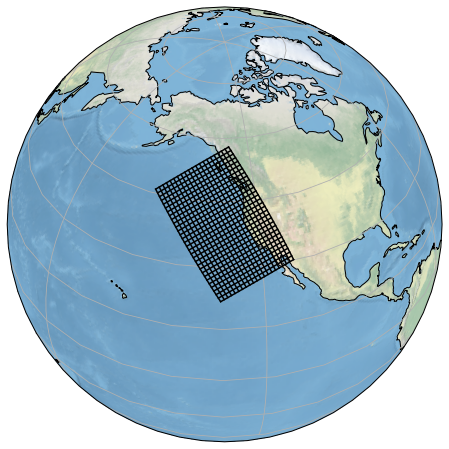

In [2]:
# Specify the grid properties
# All
# Specify the desired resolution
refineR = 1 #Inverse of nominal resolution
refineS=2   # Set to 2 for supergrid
lon_span=20.
lat_span=30.

lon0=230.0 
lat0=40.0
tilt=30.0

lamc,phic= generate_regional_spherical(lon0,lon_span,lat0,lat_span,tilt,refineR*refineS)  

mesh_plot(lamc,phic, lon0,lat0)    

In [3]:
lamc

array([[229.02010966, 229.46394572, 229.91000815, ..., 247.48258365,
        248.01163869, 248.54271757],
       [228.73471674, 229.18041457, 229.62837375, ..., 247.29667012,
        247.82921973, 248.36383908],
       [228.4475693 , 228.89511258, 229.34495275, ..., 247.10894303,
        247.64500605, 248.18318598],
       ...,
       [207.72357468, 208.2219508 , 208.72530043, ..., 231.09140641,
        231.8565001 , 232.63055948],
       [207.22731602, 207.7247966 , 208.22729495, ..., 230.62832765,
        231.39758899, 232.17608047],
       [206.72468796, 207.2211598 , 207.72269211, ..., 230.15441518,
        230.92778057, 231.71064883]])

In [4]:
phic

array([[22.0554386 , 22.309099  , 22.56061615, ..., 29.96117768,
        30.11443984, 30.26453803],
       [22.47999342, 22.73501602, 22.9878961 , ..., 30.43465527,
        30.58901367, 30.74019162],
       [22.9040429 , 23.16042981, 23.41467519, ..., 30.90786681,
        31.06333057, 31.21559742],
       ...,
       [45.24937285, 45.58551326, 45.92020498, ..., 56.57918052,
        56.82194022, 57.06085456],
       [45.60813252, 45.94568423, 46.28181524, ..., 57.01009714,
        57.25513945, 57.49634109],
       [45.96471594, 46.30367135, 46.64123471, ..., 57.43926442,
        57.68662672, 57.9301545 ]])